In [1]:
!pip install contractions==0.1.72

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 2.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 7.2 MB/s eta 0:00:00


In [2]:
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from termcolor import colored

from collections import Counter
import re
import nltk
# nltk.download('omw-1.4')
# nltk.download('wordnet2022')
#nlp = load('en_core_web_sm')
from nltk.tokenize import RegexpTokenizer
import contractions

from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
from nltk.tokenize import word_tokenize
nltk.download('wordnet')
# from nltk.stem import WordNetLemmatizer, PorterStemmer
# porter = PorterStemmer()
# lem = WordNetLemmatizer()
# nltk.download('punkt')

from nltk.stem import WordNetLemmatizer, SnowballStemmer
stemmer = SnowballStemmer("english")

from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, roc_auc_score, average_precision_score, precision_recall_curve
from sklearn.metrics import accuracy_score, classification_report

import warnings 
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
df = pd.read_csv('/kaggle/input/amazon-reviews/train.csv',  header=None)
df.columns = ['Rating', 'Title', 'Review']
df.head(10)

,Rating,Title,Review
0,2,Stuning even for the non-gamer,This sound track was beautiful! It paints the ...
1,2,The best soundtrack ever to anything.,I'm reading a lot of reviews saying that this ...
2,2,Amazing!,This soundtrack is my favorite music of all ti...
3,2,Excellent Soundtrack,I truly like this soundtrack and I enjoy video...
4,2,"Remember, Pull Your Jaw Off The Floor After He...","If you've played the game, you know how divine..."
5,2,an absolute masterpiece,I am quite sure any of you actually taking the...
6,1,Buyer beware,"This is a self-published book, and if you want..."
7,2,Glorious story,I loved Whisper of the wicked saints. The stor...
8,2,A FIVE STAR BOOK,I just finished reading Whisper of the Wicked ...
9,2,Whispers of the Wicked Saints,This was a easy to read book that made me want...


In [5]:
df.shape

(3600000, 3)

In [6]:
# Random Sample Function 
def random_sample(data):
    return data.sample(frac = 0.025)

In [7]:
## Check changes
df = random_sample(df)
df.shape

(90000, 3)

In [8]:
df = df[['Rating', 'Review']].reset_index(drop=True)

In [9]:
## Set labels to 0 and 1
def decrease_label_by_one(label):
    return label - 1

df['Rating'] = df['Rating'].apply(decrease_label_by_one)

In [10]:
## Check changes
df.head()

,Rating,Review
0,0,"So after reading some bad reviews, I thought I..."
1,0,I purchased this book because I am familiar wi...
2,0,Honeywell HZ519 Digital Low Profile Silent Com...
3,1,I think that Katie Brown is way better than Ma...
4,1,This was a very well written book concerning t...


In [11]:
## Count ratings
df.Rating.value_counts(normalize = True)

Rating
0    0.501578
1    0.498422
Name: proportion, dtype: float64

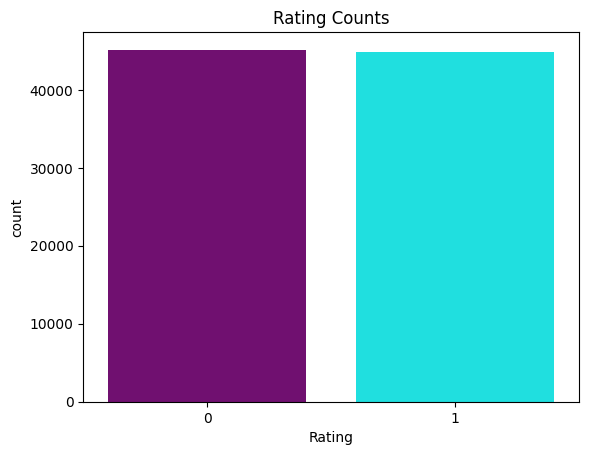

In [12]:
color_palette = ['purple', 'cyan']
sns.set_palette(color_palette) 
sns.countplot(x=df['Rating'])

plt.title('Rating Counts')
plt.show()

In [13]:
## Count null values
df.isnull().sum()

Rating    0
Review    0
dtype: int64

<h2> Processing data</h2>

In [14]:
def preprocess_text(text):
    # Text clean
    text = re.sub(r'[\W_]+', ' ', contractions.fix(re.sub(r'\d+', '', text.replace(' s ', ' ')))).lower()

    # Stopword removal
    tokens = nltk.word_tokenize(text)
    text = " ".join([token for token in tokens if token not in stop_words])

    # Data Normalization
    normalized_text = [stemmer.stem(word) for word in text.split()]
    text = ' '.join(normalized_text)

    return text

In [15]:
print(colored('Before of clean:\n', 'blue'), df.Review[8])
print(colored('After of clean:\n', 'blue'), preprocess_text(df.Review[8]))

Before of clean:
 With some of the most compelling language ever used to describe love and eros, relationships and death, Jeanette Winterson has penned a true original. This novel also has flashes of wicked humor and searing insight. You'll want to underline passages to return to later.
After of clean:
 compel languag ever use describ love ero relationship death jeanett winterson pen true origin novel also flash wick humor sear insight want underlin passag return later


In [16]:
## Cleaning and processing on the Review variable
df['Review'] = df['Review'].apply(preprocess_text)

In [17]:
df.head(10)

,Rating,Review
0,0,read bad review thought would take chanc buy m...
1,0,purchas book familiar author usual enjoy book ...
2,0,honeywel hz digit low profil silent comfort he...
3,1,think kati brown way better martha stewart eve...
4,1,well written book concern behind scene germani...
5,1,look batteri test cost lot bad review one depe...
6,0,appear follow book advic along exampl parent c...
7,0,first mb card purchas would hold mb data deter...
8,1,compel languag ever use describ love ero relat...
9,0,product come readi use come detail instruct sa...


# Exploration Data Analysis (EDA)

In [18]:
## Frequency Words
words = Counter(' '.join(df['Review'].to_list()).split())
Frequency_words = pd.DataFrame([words]).transpose().reset_index().rename(columns = {'index': 'Words', 0:'Frequency' })
Frequency_words = Frequency_words.sort_values('Frequency',ascending=False).reset_index(drop='index').reset_index().rename(columns={'index':'Rank'})
Frequency_words['Rank'] = Frequency_words['Rank'].apply(lambda x : x+1)
Frequency_words.head(20)

,Rank,Words,Frequency
0,1,book,51262
1,2,one,34136
2,3,like,27620
3,4,would,25537
4,5,read,22397
5,6,use,21996
6,7,get,21272
7,8,good,21252
8,9,great,20454
9,10,time,20436


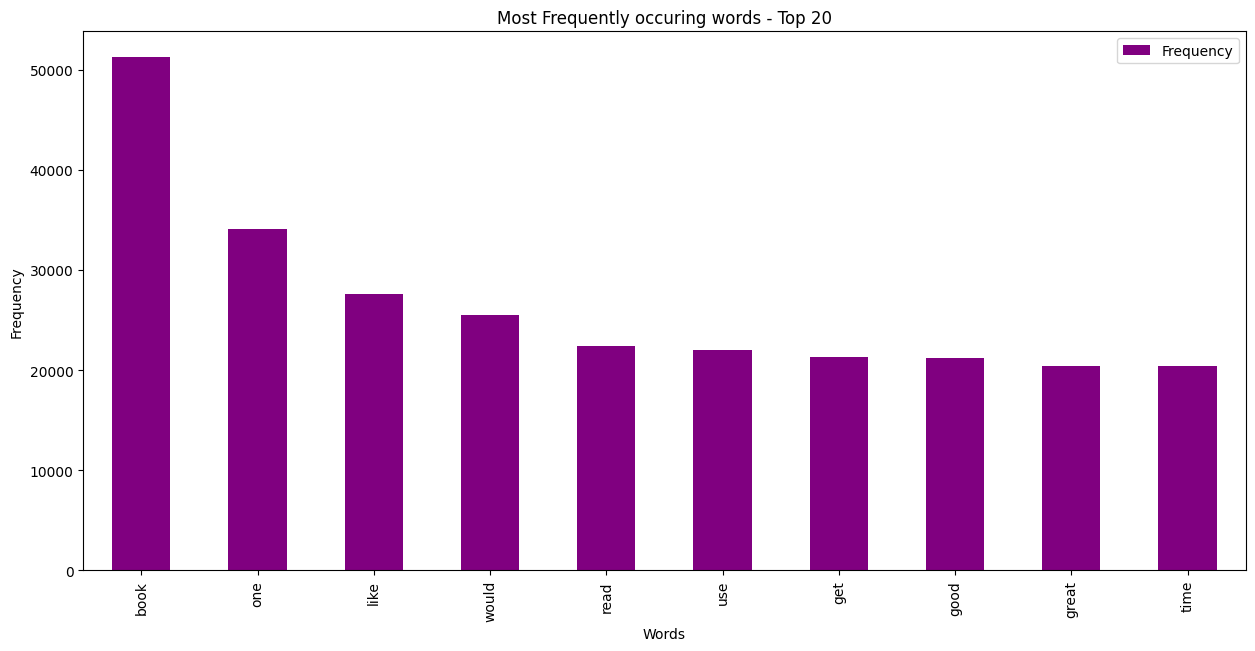

In [19]:
Top10 = Frequency_words[['Words','Frequency']].head(10)
Top10.plot(x="Words", y="Frequency", kind='bar',  figsize=(15,7), color = 'purple')
plt.title("Most Frequently occuring words - Top 20")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.show()

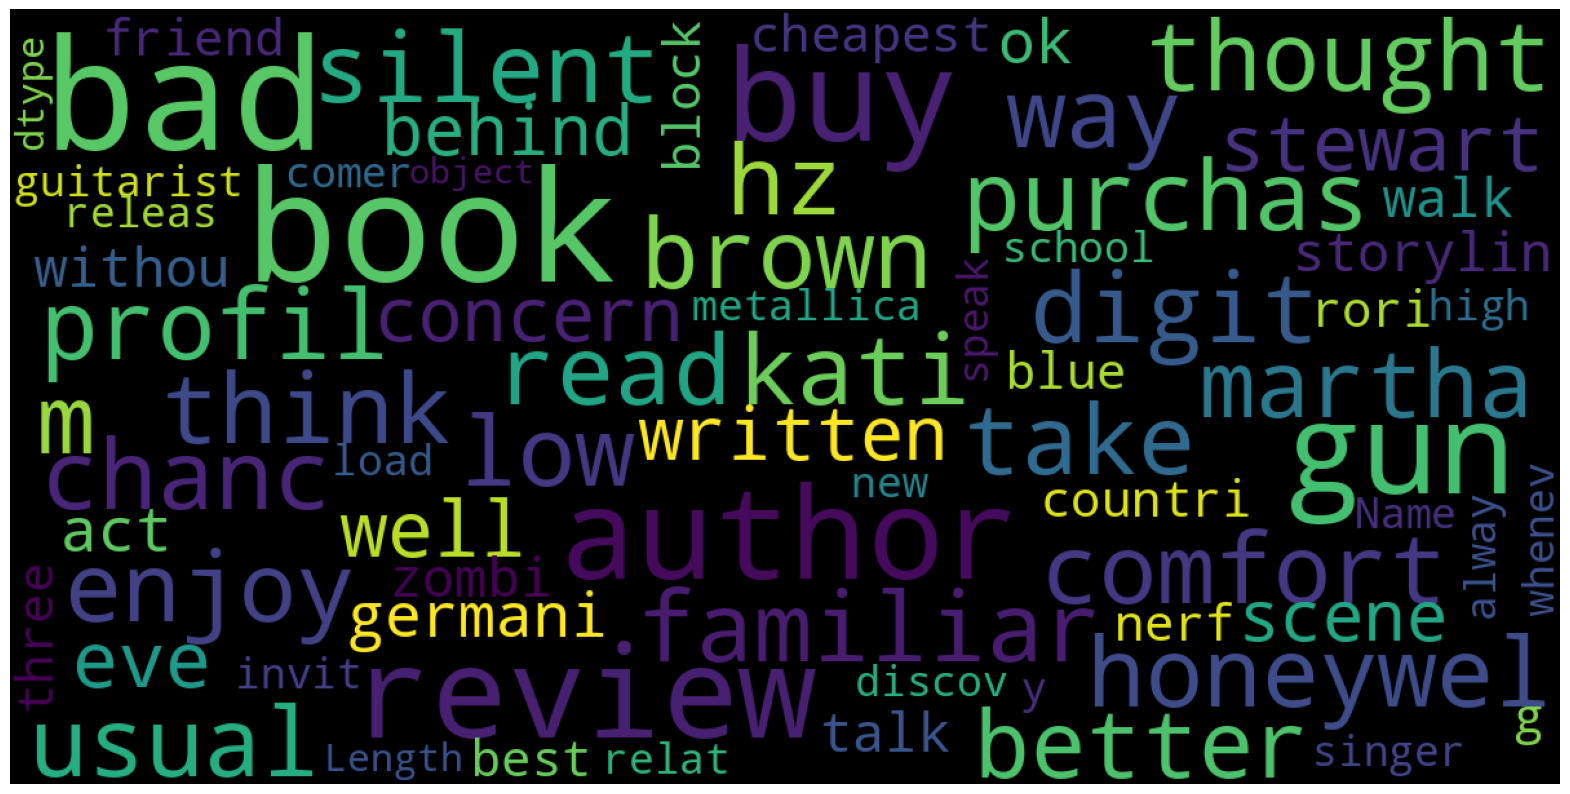

In [20]:
from wordcloud import WordCloud
#  WordCloud chart 

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color = 'black',
        max_words = 350,
        max_font_size = 40, 
        scale = 3,
        random_state = 42
    ).generate(str(data))

    fig = plt.figure(1, figsize = (20, 20))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 2.3)

    plt.imshow(wordcloud)
    plt.show()

# print wordcloud
show_wordcloud(df["Review"])

In [21]:
Tf = TfidfVectorizer(max_features = 20000, ngram_range=(1,3), analyzer ='char')
Tf

TfidfVectorizer(analyzer='char', max_features=20000, ngram_range=(1, 3))

In [22]:
X = Tf.fit_transform(df['Review'])
y = df['Rating']

# Train-Test Split

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 123)

In [24]:
lr = LogisticRegression(max_iter=5000)

# Define the preprocessing steps for numeric features
lr.fit(X_train, y_train)

# Evaluate the model on the testing data
lr_preds = lr.predict(X_test)

# Evaluate the accuracy of the model
lr_accuracy = accuracy_score(y_test, lr_preds)*100
print(f"Accuracy of Linear Regression Model: {lr_accuracy:.2f}%")

Accuracy of Linear Regression Model: 81.81%


In [25]:
svm = LinearSVC()

# Define the preprocessing steps for numeric features
svm.fit(X_train, y_train)

# Predict the ratings for the test set
svm_preds = svm.predict(X_test)

# Evaluate the accuracy of the model
svm_accuracy = accuracy_score(y_test, svm_preds)*100
print(f"Accuracy of SVM Model: {svm_accuracy:.2f}%")

Accuracy of SVM Model: 82.46%


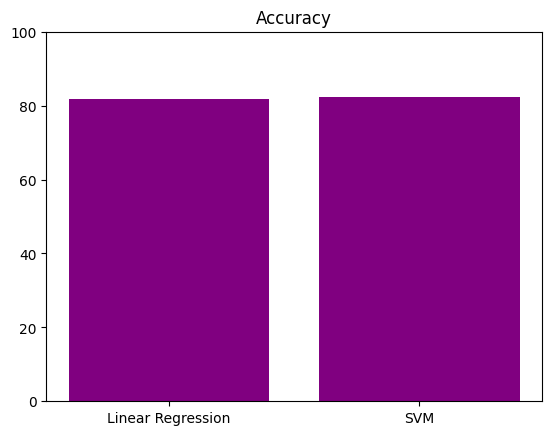

In [26]:
models = ['Linear Regression', 'SVM']
accuracy = [lr_accuracy, svm_accuracy]
plt.bar(models, accuracy)
plt.title('Accuracy')
plt.ylim(0, 100)
plt.show()

In [30]:
## Classification report
print(classification_report(y_test,lr_preds))
print(classification_report(y_test,svm_preds))

              precision    recall  f1-score   support

           0       0.82      0.82      0.82      9102
           1       0.81      0.82      0.82      8898

    accuracy                           0.82     18000
   macro avg       0.82      0.82      0.82     18000
weighted avg       0.82      0.82      0.82     18000

              precision    recall  f1-score   support

           0       0.83      0.82      0.83      9102
           1       0.82      0.83      0.82      8898

    accuracy                           0.82     18000
   macro avg       0.82      0.82      0.82     18000
weighted avg       0.82      0.82      0.82     18000



In [31]:
def predict_sentiment(comment, vectorizer, model):
    vec = vectorizer.transform([comment])
    prediction = model.predict(vec)
    
    if prediction == 0:
        print(colored("Negative", "red"))
    else:
        print(colored("Positive", "blue"))

In [32]:
x = "Lousy product. The quality is very low."
predict_sentiment(x, Tf, svm)

Negative


In [33]:
x1 = "The quality is bad."
predict_sentiment(x1, Tf, lr)

Negative


In [34]:
x2 = "The book is awesome."
predict_sentiment(x2, Tf, svm)

Positive
